In [1]:
# # TODO: A more generic way is needed here to load the path
# import sys

# sys.path.append(
#     "/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src"
#     # "/global/homes/p/peishi89/jax-watershed/src"
# )

In [1]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import jax.numpy as jnp

from jax_canoak.subjects.utils import es as fes

# from jax_canoak.shared_utilities.forcings.get_forcing import get_modis_lai
# from jax_canoak.shared_utilities.forcings.get_forcing import get_modis_et

%load_ext autoreload
%autoreload 2

In [2]:
dir_flux_data = Path("../../data/fluxtower/US-Hn1")
dir_modis_data = Path("../../data/modis/US-Hn1")
f_forcing = dir_flux_data / "US-Hn1.csv"
f_forcing2 = dir_flux_data / "Hn1_2016-2020.xlsx"
f_chamber = dir_flux_data / "Hn1_chamber.csv"
# f_modis_lai = dir_modis_data / "LAI" / "filtered_scaled_Lai_500m.csv"
# modis_lai_scale_factor = 0.1
f_modis_lai = dir_modis_data / "MCD15A3H" / "filtered_scaled_Lai_500m.csv"
f_modis_le = dir_modis_data / "MOD16A2GF" / "filtered_scaled_LE_500m.csv"

remove_neg_le = True

modis_lai_scale_factor = 0.1
modis_le_scale_factor = 1e4
pixel_ind = 144

# Flux tower data

## Till 2020

In [3]:
# Read the dataframe
df = pd.read_csv(f_forcing)

In [4]:
# Vegetation height
# Sagebrush: ~1.2m https://workbasedlearning.pnnl.gov/pals/resource/cards/sagebrush.stm
df["veg_ht"] = 1.5

In [5]:
# Get the time frame
df.index = pd.to_datetime(df["TIMESTAMP_END"], format="%Y-%m-%d %H:%M:%S")

<Axes: xlabel='TIMESTAMP_END'>

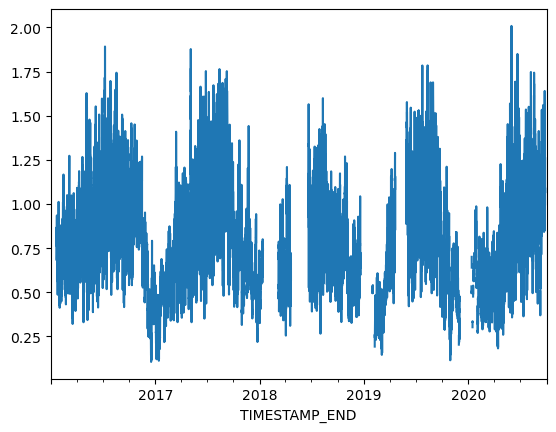

In [6]:
# Calculate vapor pressure from air temperature and relative humidity
es = fes(df["Tair"].values + 273.15)
# ea = es - df['VPD'].values*1000
df["rH"] = np.clip(df["rH"], a_max=100, a_min=0)
ea = es * df["rH"].values / 100

df["eair"] = ea / 1e3  # kPa
df["eair"].plot()

## Till 2022

<Axes: xlabel='TIMESTAMP_END'>

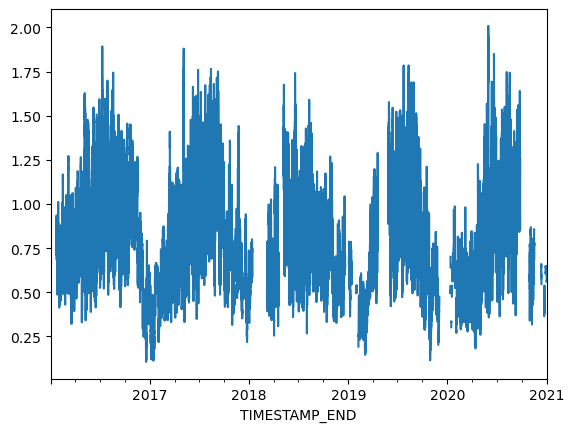

In [7]:
# Read the dataframe
df2 = pd.read_excel(f_forcing2)

# Vegetation height
df2["veg_ht"] = 1.5

# Get the time frame
df2.index = pd.to_datetime(df2["TIMESTAMP_END"], format="%Y-%m-%d %H:%M:%S")

# Calculate vapor pressure from air temperature and relative humidity
es = fes(df2["Tair"].values + 273.15)
# ea = es - df['VPD'].values*1000
df2["rH"] = np.clip(df2["rH"], a_max=100, a_min=0)
ea = es * df2["rH"].values / 100

df2["eair"] = ea / 1e3  # kPa
df2["eair"].plot()

In [9]:
# Only look at the new datasets after year of 2019
df2 = df2['2019-01-01':]


## Combine the two dataframes

In [10]:
# The following information is needed to drive CANOAK
varns = [
    "Year", "DoY", "Hour", "Tair", "Rg", "eair", "WS_x",
    "CO2", "PA", "Ustar", "TS_15cm", "SWC_15cm", "veg_ht",
    "P_mm", "LE", "H", "NETRAD", "G_5cm", "PAR", "FC"
]

In [11]:
df_combined = df[varns].combine_first(df2[varns])

In [34]:
df_combined

,Year,DoY,Hour,Tair,Rg,eair,WS_x,CO2,PA,Ustar,...,P_mm,LE,H,NETRAD,G_5cm,PAR,FC,LAI,LE_MODIS,Rsoil
TIMESTAMP_END,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:30:00,2016,1,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,183.462644,NaN
2016-01-01 01:00:00,2016,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,183.477011,NaN
2016-01-01 01:30:00,2016,1,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,183.491379,NaN
2016-01-01 02:00:00,2016,1,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,183.505747,NaN
2016-01-01 02:30:00,2016,1,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,183.520115,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 22:00:00,2020,366,22.0,-2.244841,-3.213494,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,-53.74980,-12.921714,0.0,NaN,1.0,185.780303,NaN
2020-12-31 22:30:00,2020,366,22.5,-2.623749,-3.183672,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,-52.66870,-12.578849,0.0,NaN,1.0,185.835227,NaN
2020-12-31 23:00:00,2020,366,23.0,-3.027672,-2.511667,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,-44.18350,-12.293995,0.0,NaN,1.0,185.890152,NaN


# MODIS data


<Axes: xlabel='2'>

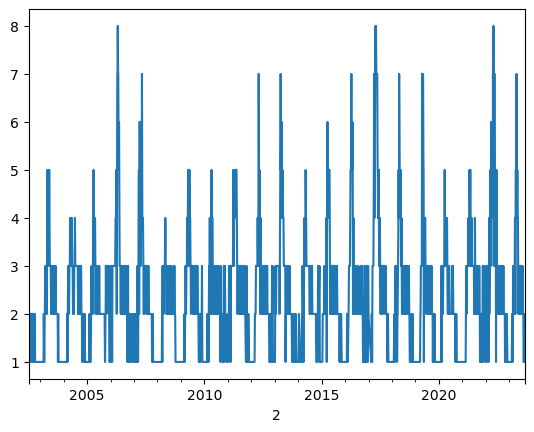

In [12]:
df_modis_lai = pd.read_csv(f_modis_lai, header=None)
df_modis_lai.index = df_modis_lai[2].apply(
    lambda x: pd.to_datetime(x[1:], format="%Y%j")
)
df_modis_lai["LAI"] = df_modis_lai[4 + pixel_ind].apply(
    lambda x: float(x) / modis_lai_scale_factor if x != "F" else np.nan
)
df_modis_lai = df_modis_lai[["LAI"]]
df_modis_lai = df_modis_lai.resample("30min").interpolate()
df_modis_lai["LAI"].plot()

<Axes: xlabel='2'>

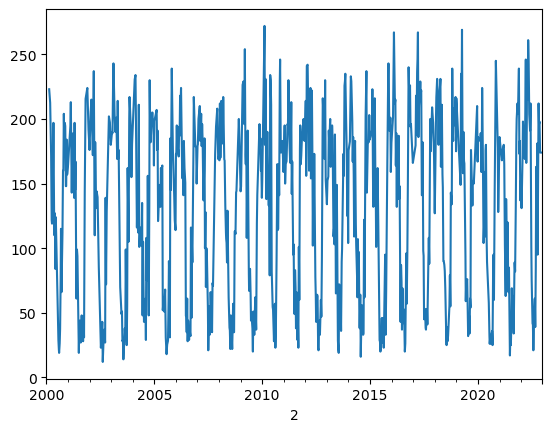

In [13]:
df_modis_le = pd.read_csv(f_modis_le, header=None)
df_modis_le.index = df_modis_le[2].apply(lambda x: pd.to_datetime(x[1:], format="%Y%j"))
df_modis_le["LE_MODIS"] = df_modis_le[4 + pixel_ind].apply(
    lambda x: float(x) / modis_le_scale_factor if x != "F" else np.nan
)
df_modis_le = df_modis_le[["LE_MODIS"]]
df_modis_le = df_modis_le.resample("30min").interpolate()
df_modis_le["LE_MODIS"].plot()

In [14]:
df_modis = pd.concat([df_modis_lai, df_modis_le])
df_modis.head()

,LAI,LE_MODIS
2,,
2002-07-04 00:00:00,2.000000,NaN
2002-07-04 00:30:00,1.994792,NaN
2002-07-04 01:00:00,1.989583,NaN
2002-07-04 01:30:00,1.984375,NaN
2002-07-04 02:00:00,1.979167,NaN


In [15]:
df_modis = df_modis_lai.join(df_modis_le)

In [16]:
# data_json['subset'][5]['data']
# Get MODIS LAI
# start, end = df.index[0], df.index[-1]
# df_modis = get_modis_lai("US-Hn1", start, end, method='mean', sample_freq="30min")
# df_modis, data_json = get_modis_lai(
#   "US-Hn1", start, end, method='mean', sample_freq="30min"
# )
# df_modis["LAI"].plot()

In [17]:
# df_modis = pd.read_csv(f_modis_lai, header=None)
# df_modis.index = df_modis[2].apply(lambda x: pd.to_datetime(x[1:], format="%Y%j"))
# df_modis["LAI"] = df_modis[6].apply(
#     lambda x: float(x) / modis_lai_scale_factor if x != "F" else np.nan
# )
# df_modis = df_modis[["LAI"]]
# df_modis = df_modis.resample("30min").interpolate()
# df_modis["LAI"].plot()

# Soil respiration data

In [18]:
# Get soil respiration
df_chamber = pd.read_csv(f_chamber)
df_chamber["Timestamp"] = pd.to_datetime(
    df_chamber["Timestamp"], format="%Y-%m-%d %H:%M:%S"
)
df_chamber.set_index("Timestamp", inplace=True)
df_chamber = df_chamber.resample("30T").mean()

# Combine data

In [19]:
df_combined = df_combined.join(df_modis)
df_combined = df_combined.join(df_chamber[["Rsoil"]])

# Forcings

In [20]:
# The following information is needed to drive CANOAK
in_varns = [
    "Year",
    "DoY",
    "Hour",
    "Tair",
    "Rg",
    "eair",
    "WS_x",
    "CO2",
    "PA",
    "Ustar",
    "TS_15cm",
    "SWC_15cm",
    "veg_ht",
    # "P_mm",
    "LAI",
]

<Axes: xlabel='TIMESTAMP_END'>

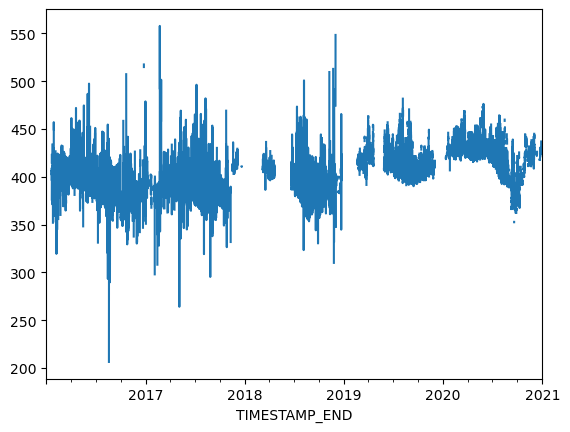

In [21]:
# Clean up the negative CO2 ppm
df_combined.loc[df_combined["CO2"] <= 100, "CO2"] = np.nan
df_combined["CO2"].plot()

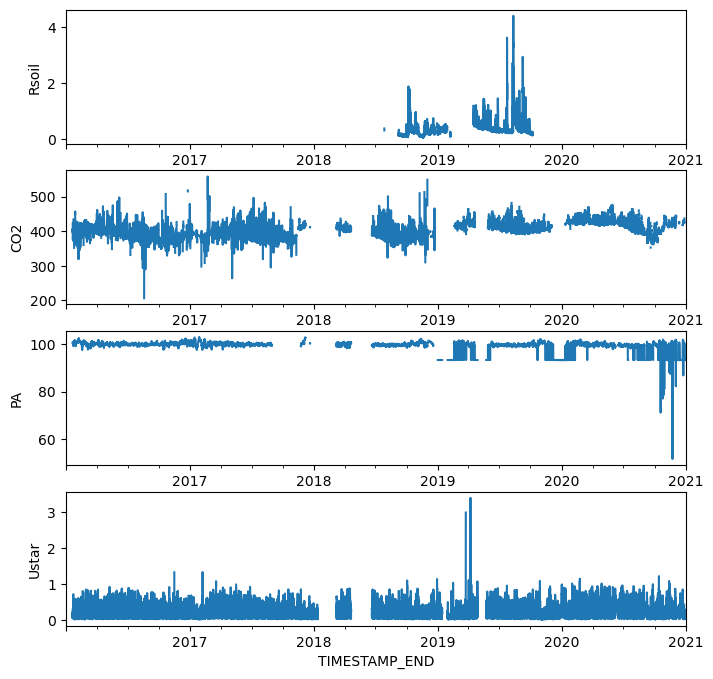

In [22]:
varns = ["Rsoil", "CO2", "PA", "Ustar"]
fig, axes = plt.subplots(len(varns), 1, figsize=(8, 8))
for i, varn in enumerate(varns):
    ax = axes[i]
    df_combined[varn].plot(ax=ax)
    ax.set(ylabel=varn)

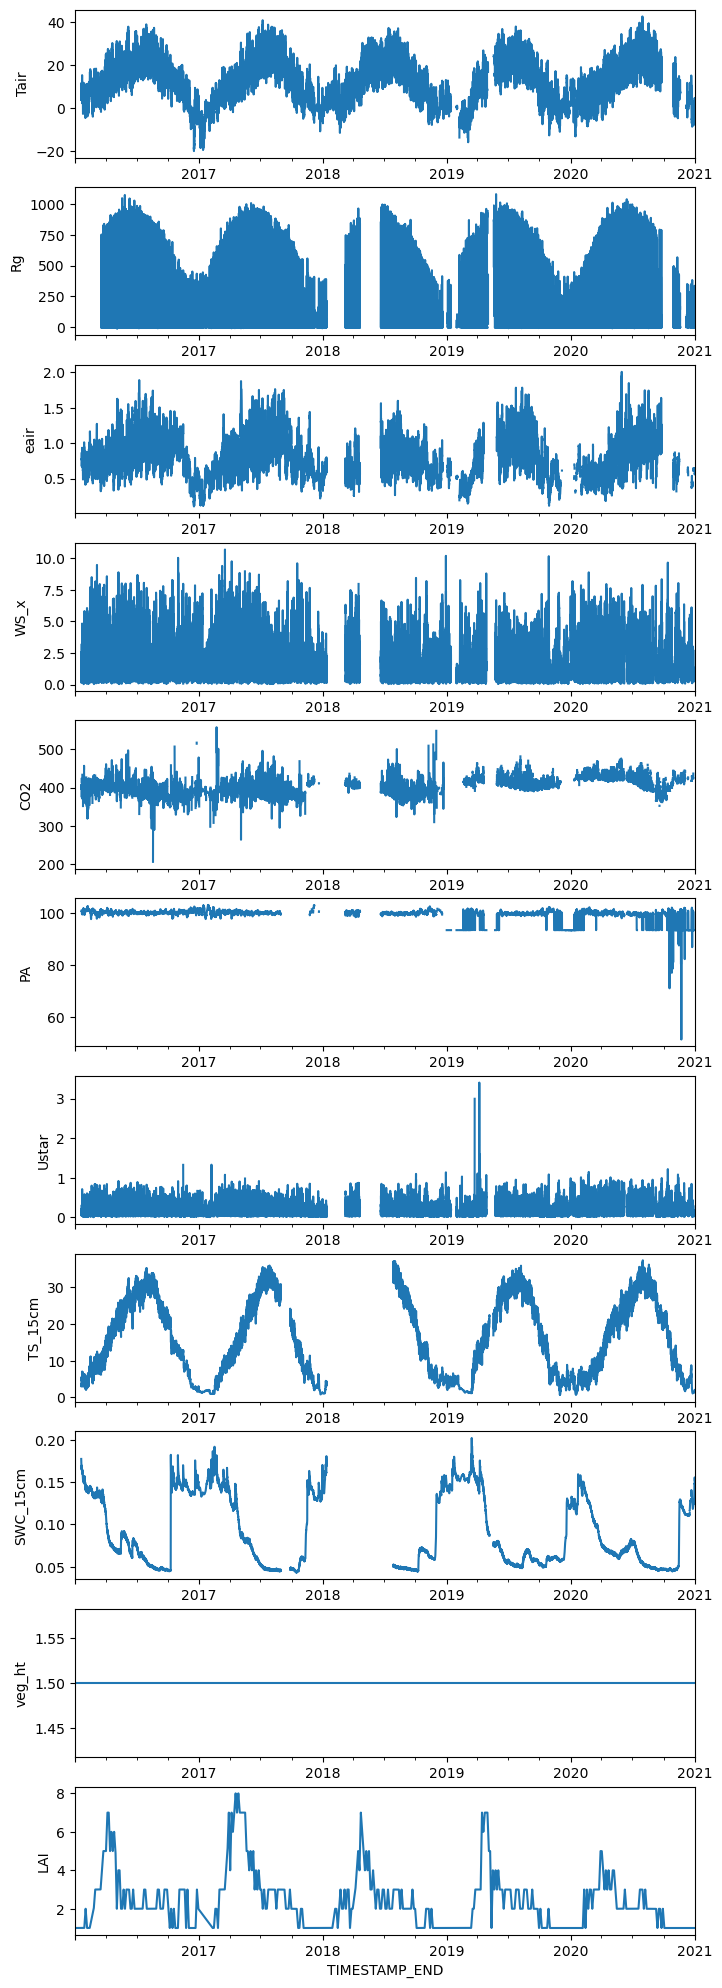

In [23]:
varns = in_varns[3:]
fig, axes = plt.subplots(len(varns), 1, figsize=(8, 25))
for i, varn in enumerate(varns):
    ax = axes[i]
    df_combined[varn].plot(ax=ax)
    ax.set(ylabel=varn)

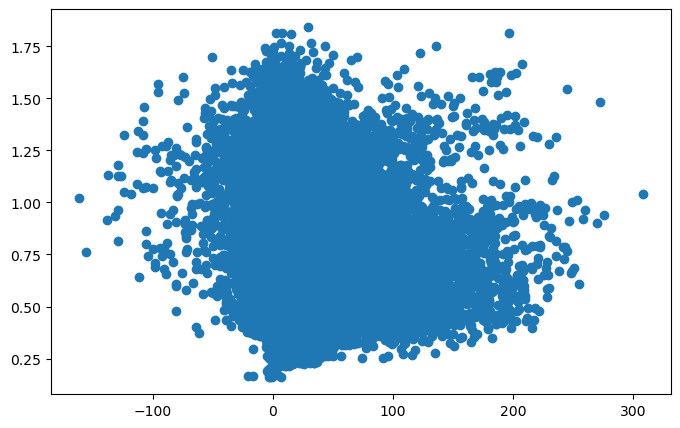

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.scatter(df["LE"], df["eair"])

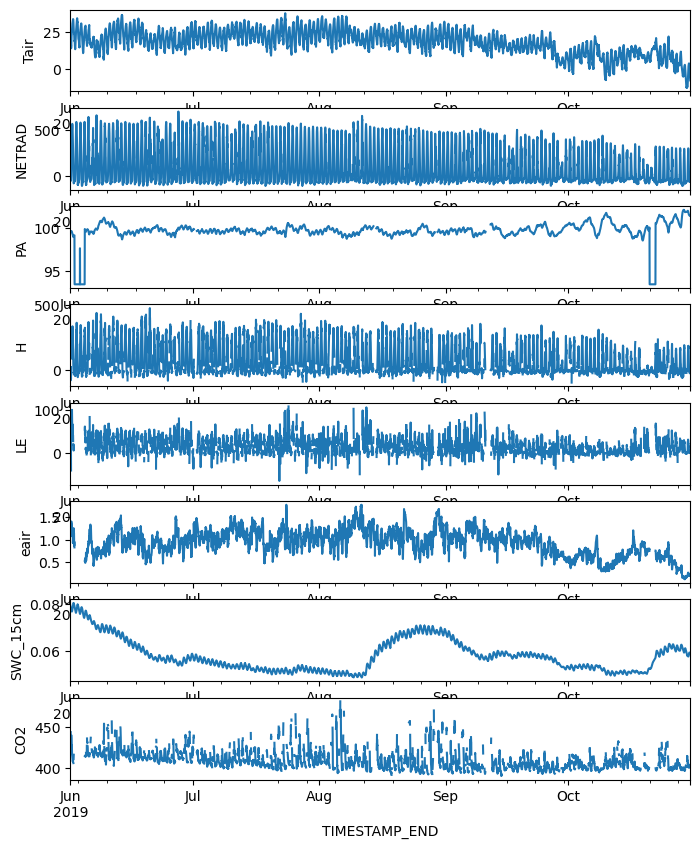

In [25]:
varns = ["Tair", "NETRAD", "PA", "H", "LE", "eair", "SWC_15cm", "CO2"]
# start, end = "2017-06-01", "2017-06-30"
# start, end = "2017-06-22", "2017-06-27"
start, end = "2019-06-01", "2019-10-30"
fig, axes = plt.subplots(len(varns), 1, figsize=(8, 10))
for i, varn in enumerate(varns):
    ax = axes[i]
    df_combined.loc[start:end, varn].plot(ax=ax)
    ax.set(ylabel=varn)

In [26]:
# Save the forcing data
start, end = "2016-06-01", "2017-12-30"
df_save = df_combined[in_varns][start:end]
df_save.interpolate(inplace=True)
np.savetxt(dir_flux_data / "US-Hn1-forcings-v2.csv", df_save.values, delimiter=",")

In [27]:
# Save the forcing data -- test
start_test, end_test = "2019-06-01", "2019-10-30"
df_save = df_combined[in_varns][start_test:end_test]
df_save.interpolate(inplace=True)
np.savetxt(dir_flux_data / "US-Hn1-forcings-test-v2.csv", df_save.values, delimiter=",")

# Responses/fluxes/rain

In [28]:
if remove_neg_le:
    df_combined["LE"][df_combined["LE"] < 0] = np.nan

/tmp/ipykernel_1468837/997501509.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_combined["LE"][df_combined["LE"] < 0] = np.nan


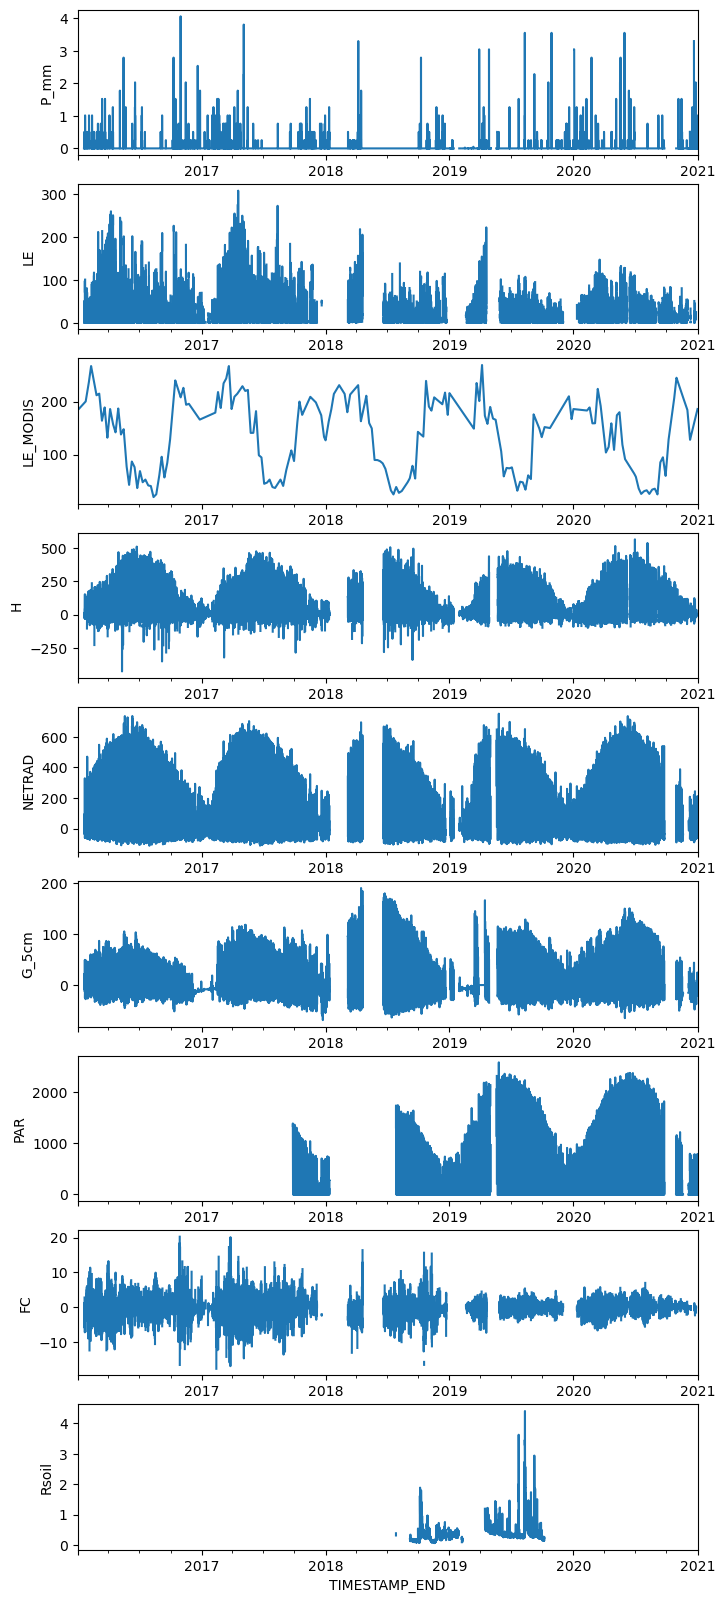

In [29]:
# The data to compare
out_varns = ["P_mm", "LE", "LE_MODIS", "H", "NETRAD", "G_5cm", "PAR", "FC", "Rsoil"]
varns = out_varns
fig, axes = plt.subplots(len(varns), 1, figsize=(8, 20))
for i, varn in enumerate(varns):
    ax = axes[i]
    df_combined[varn].plot(ax=ax)
    ax.set(ylabel=varn)

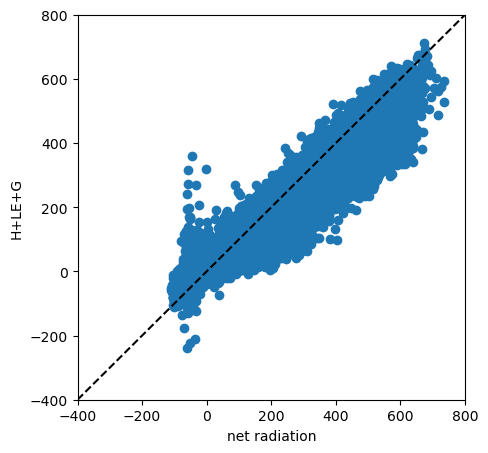

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
lim = [-400, 800]
ax.scatter(df_combined["NETRAD"], df_combined["H"] + df_combined["LE"] + df_combined["G_5cm"])
ax.plot(lim, lim, "k--")
ax.set(xlim=lim, ylim=lim, xlabel="net radiation", ylabel="H+LE+G");

In [31]:
# Save the data to compare
df_save = df_combined[out_varns][start:end]
df_save.interpolate(inplace=True)
# np.savetxt('US-Hn1-fluxes.csv', df_save.values, delimiter=',')
if remove_neg_le:
    df_save.to_csv(dir_flux_data / "US-Hn1-fluxes-nonegle-v2.csv", sep=",")
else:
    df_save.to_csv(dir_flux_data / "US-Hn1-fluxes-v2.csv", sep=",")

In [32]:
# Save the data to compare
df_save = df_combined[out_varns][start_test:end_test]
df_save.interpolate(inplace=True)
# np.savetxt('US-Hn1-fluxes.csv', df_save.values, delimiter=',')
if remove_neg_le:
    df_save.to_csv(dir_flux_data / "US-Hn1-fluxes-nonegle-test-v2.csv", sep=",")
else:
    df_save.to_csv(dir_flux_data / "US-Hn1-fluxes-test-v2.csv", sep=",")